In [365]:
# All imports
import numpy as np
from scipy.stats import skew
from scipy import ndimage
import cv2

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import torchvision.transforms as transforms
from torchinfo import summary

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [366]:
# GPU (Nvidia)
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {dev} for inference')

Using cuda for inference


Loading Caltech101 dataset

In [367]:
dataset_path = "C:\Kaushik\ASU\CSE 515 - Multimedia and Web Databases\Project\Datasets"

dataset = datasets.Caltech101(
    root="C:\Kaushik\ASU\CSE 515 - Multimedia and Web Databases\Project\Datasets",
    download=False,
)


Select image by ID

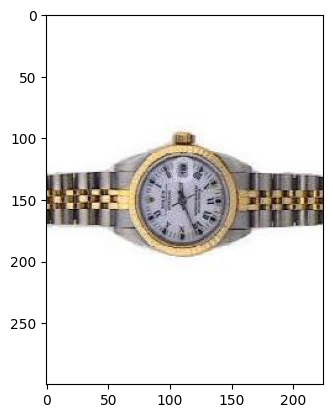

In [368]:
selected_image_id = int(input("Enter image ID: "))
sample_image, sample_label = dataset[selected_image_id]
plt.imshow(sample_image)
plt.show()


In [369]:
# Class transform to partition image into rows x cols grid
class GridPartition:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols

    def __call__(self, img):
        img_width, img_height = img.size
        cell_width = img_width // self.cols
        cell_height = img_height // self.rows

        grids = []
        for i in range(self.rows):
            for j in range(self.cols):
                left = j * cell_width
                top = i * cell_height
                right = left + cell_width
                bottom = top + cell_height
                grid = img.crop((left, top, right, bottom))
                grids.append(grid)

        return grids    

Feature model 1: Color moments

In [371]:
def compute_color_moments(image):
    image = np.array(image)  # Convert PIL Image to NumPy array
    moments = []

    for channel in range(3):  # Iterate over RGB channels
        channel_data = image[:, :, channel]
        mean = np.mean(channel_data)    # mean
        std_dev = np.std(channel_data)  # std. dev.
        skewness = skew(channel_data, axis=None)    # skewness
        moments.append([mean, std_dev, skewness])

    return moments

# Iterate over grid cells and return as 1-d array for easier resizing by torch
def compute_color_moments_for_grid(grid):
    color_moments = [compute_color_moments(grid_cell) for grid_cell in grid]
    return np.array(color_moments).flatten()


In [372]:
def combine_color_moments(grid_color_moments):
    return torch.Tensor(grid_color_moments).view(10, 10, 3, 3)  # resize as needed


Composed color moment transform

In [358]:
CM_transform = transforms.Compose(
    [
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(rows=10, cols=10),    # partition into grid of 10 rows, 10 columns as a list
        compute_color_moments_for_grid, # compute color moments
        combine_color_moments,  # convert to tensor and resize as needed
    ]
)

cm_fd = CM_transform(sample_image)
print(np.array(cm_fd))


[[[[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]
   [ 2.55000000e+02  0.00000000e+00             nan]]

  [[ 2.55000000e+02  0.00000000e+0

(note that skewness is NaN when all elements are equal i.e. std. dev. = 0)

Feature model 2: Histogram Oriented Gradients (HOG)

In [376]:
def compute_gradient_histogram(grid_cell):
    histograms = []

    # Convert grid cell to NumPy array
    grid_array = np.array(grid_cell, dtype=np.uint8)

    # Compute the gradient using first-order central differences
    dx = cv2.Sobel(grid_array, cv2.CV_32F, 1, 0, ksize=1)   # first order x derivative = [-1, 0, 1]
    dy = cv2.Sobel(grid_array, cv2.CV_32F, 0, 1, ksize=1)   # first order y derivative = [-1, 0, 1]^T

    # Compute magnitude and direction of gradients
    magnitude = np.sqrt(dx**2 + dy**2)
    direction = np.arctan2(dy, dx) * 180 / np.pi  # in degrees
    
    # Compute histogram
    histogram, _ = np.histogram(direction, bins=9, range=(-180, 180), weights=magnitude)

    histograms.append(histogram)

    return histograms


In [377]:
def compute_histograms_for_grid(grid):
    histograms = [compute_gradient_histogram(grid_cell) for grid_cell in grid]
    return np.array(histograms).flatten()


In [378]:
def combine_histograms(grid_histograms):
    return torch.Tensor(grid_histograms).view(10, 10, 9)


In [379]:
HOG_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((100, 300)),  # resize to H:W=100:300
        GridPartition(rows=10, cols=10),    # partition into grid of 10 rows, 10 columns as a list
        compute_histograms_for_grid,
        combine_histograms,
    ]
)

hog_fd = HOG_transform(sample_image)
hog_fd


tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.000

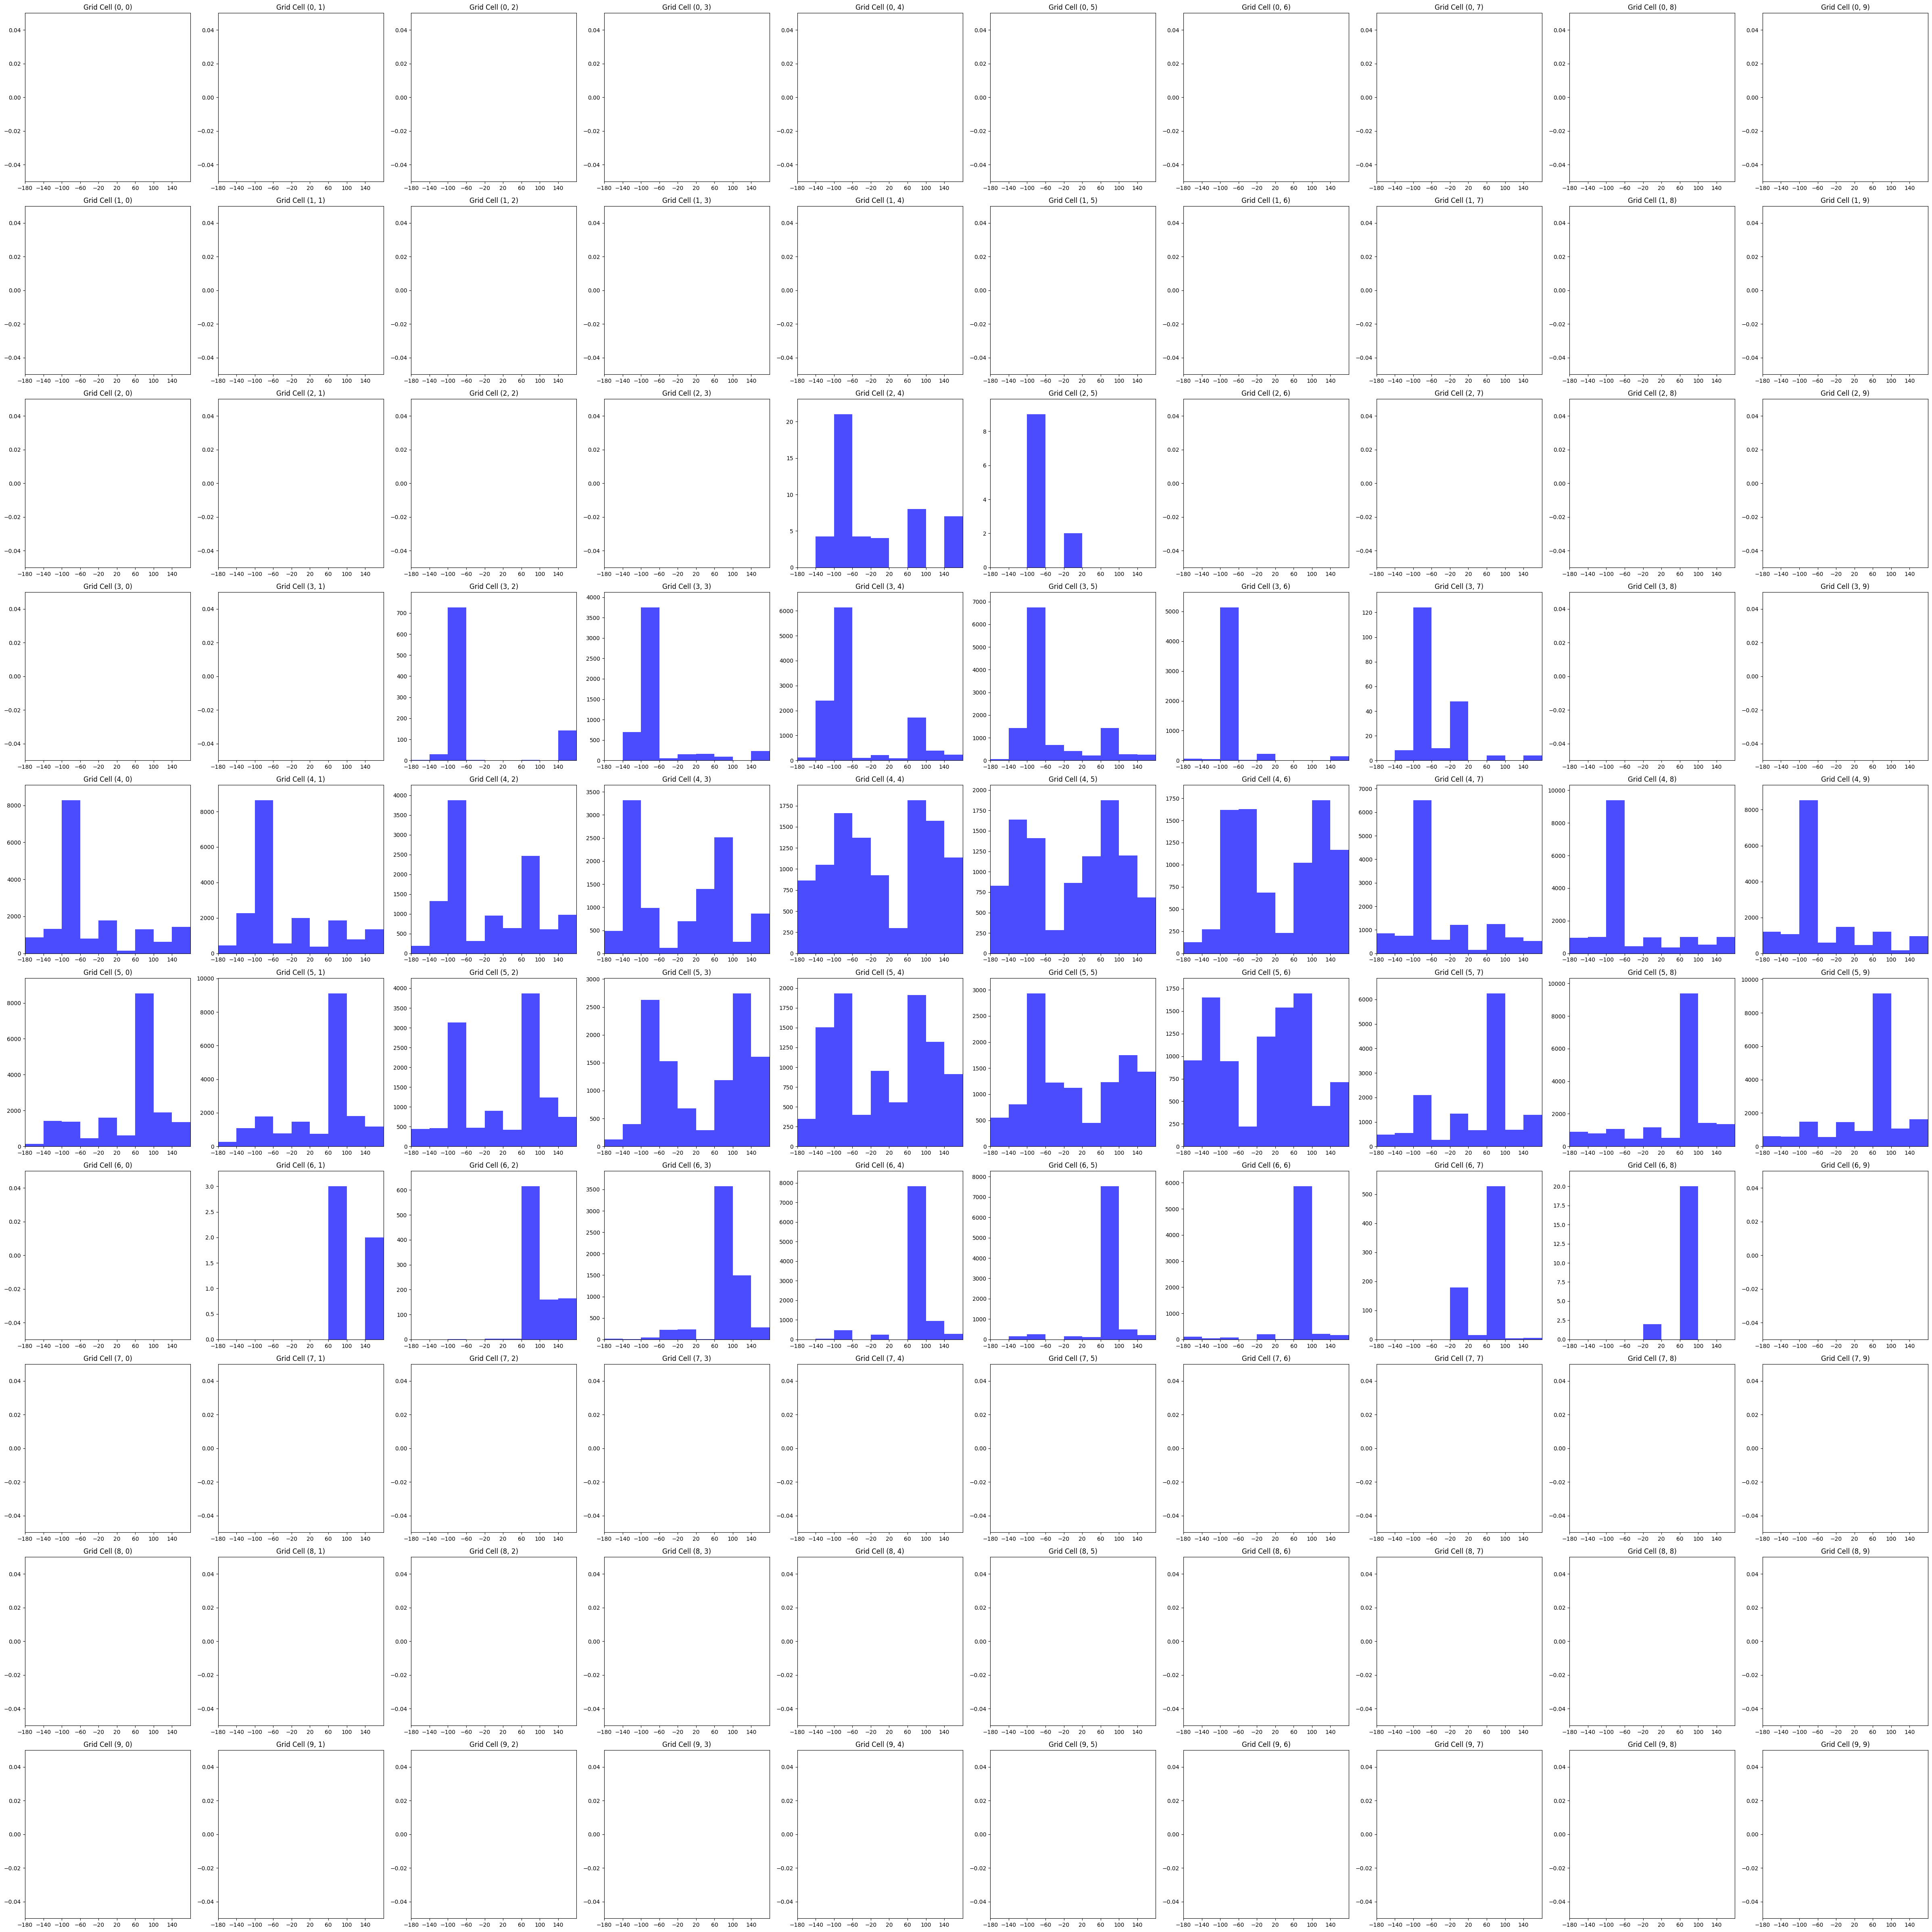

In [381]:
# # The 'hog' should now contain the 10x10x9 feature descriptor
# # Reshape it to a 10x10 grid of histograms, each of shape (9,)
histograms = np.array(hog_fd.reshape(10, 10, 9))

# # Visualize the histograms
fig, axes = plt.subplots(10, 10, figsize=(48, 48))
for i in range(10):
    for j in range(10):
        histogram = histograms[i, j]
        angles = np.linspace(-180, 180, 9, endpoint=False)

        axes[i, j].bar(angles, histogram, width=40, align="edge", color="b", alpha=0.7)
        axes[i, j].set_xlim(-180, 180)
        axes[i, j].set_ylim(0, np.max(histogram) * 1.1)
        axes[i, j].set_xticks([-180, -140, -100, -60, -20, 20, 60, 100, 140])
        axes[i, j].set_title(f"Grid Cell ({i}, {j})")

plt.tight_layout()
plt.show()


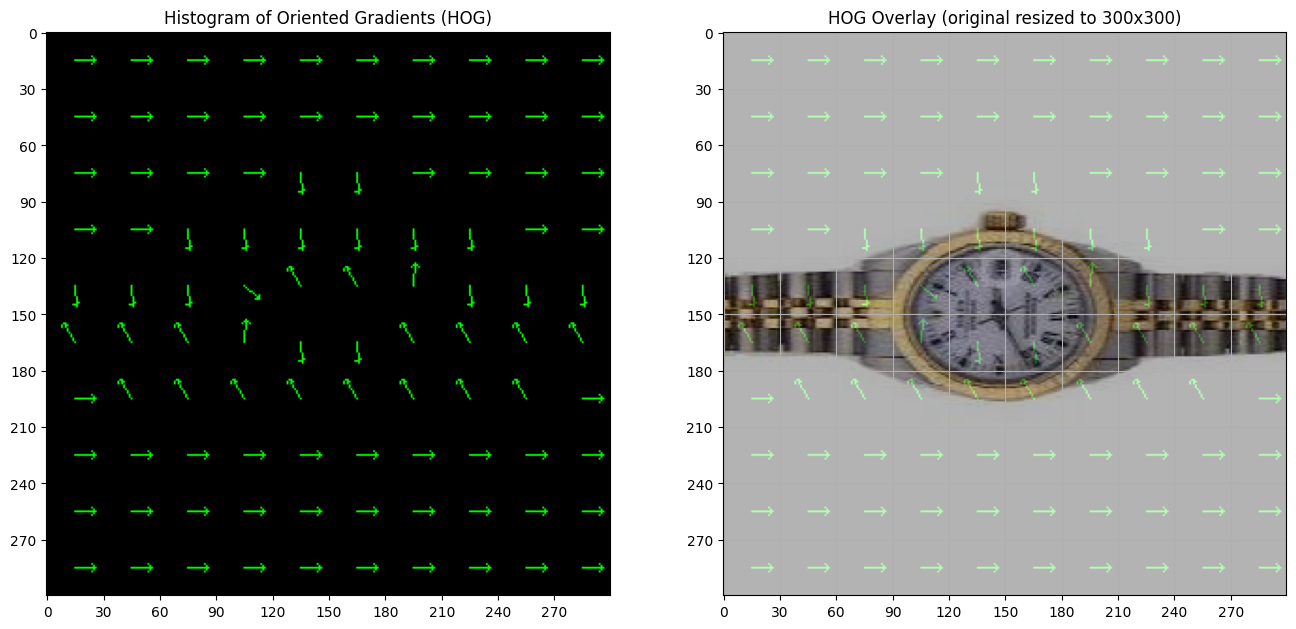

In [382]:
# Create a blank canvas to visualize the HOG features
block_size = 30
canvas = np.zeros((10 * block_size, 10 * block_size, 3), dtype=np.uint8)

# Define the arrow properties (e.g., arrow length and color)
base_arrow_length = block_size * 3 / 4  # Adjust as needed
arrow_color = (0, 255, 0)  # Green arrows for gradient direction

# Loop through each block in the HOG feature descriptor
for i in range(10):
    for j in range(10):
        block = hog_fd[i, j]
        x, y = j * block_size, i * block_size  # Top-left corner of the block

        # Compute the center position of the block
        center_x = x + block_size // 2
        center_y = y + block_size // 2

        # Find n (arbitrary) most dominant directions
        num_dir = 1
        dominant_directions = [
            pair
            for pair in sorted(
                list(enumerate(block)), key=lambda x: x[1], reverse=True
            )[:num_dir]
        ]

        for idx, (direction, magnitude) in enumerate(dominant_directions):
            arrow_thickness = num_dir - idx
            # arrow_start_x = int(
            #     center_x - ((base_arrow_length * np.cos(np.deg2rad(direction * 40))) / 2)
            # )
            # arrow_start_y = int(
            #     center_y - ((base_arrow_length * np.sin(np.deg2rad(direction * 40))) / 2)
            # )
            arrow_end_x = int(
                center_x
                + ((base_arrow_length * np.cos(np.deg2rad(direction * 40))) / 2)
            )
            arrow_end_y = int(
                center_y
                + ((base_arrow_length * np.sin(np.deg2rad(direction * 40))) / 2)
            )

            # Draw the arrow on the canvas
            cv2.arrowedLine(
                canvas,
                (center_x, center_y),
                # (arrow_start_x, arrow_start_y),
                (arrow_end_x, arrow_end_y),
                arrow_color,
                thickness=arrow_thickness,
                tipLength=0.2,
            )

# Display the canvas with HOG feature visualization alongside resized image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=False)

ax1.imshow(canvas)
ax1.set_title('Histogram of Oriented Gradients (HOG)')

ax2.imshow(transforms.Resize((300,300))(sample_image))
ax2.imshow(canvas, alpha=0.3) # overlay HOG on image
# ax.imshow(transforms.Resize((300, 300))(sample_image))
ax2.set_title('HOG Overlay (original resized to 300x300)')

ax1.set_xticks(range(0, 300, 30))
ax1.set_yticks(range(0, 300, 30))
ax2.set_xticks(range(0, 300, 30))
ax2.set_yticks(range(0, 300, 30))
plt.grid()
plt.show()
